In [276]:
# Imports
import numpy as np
import pandas as pd
from collections import Counter, defaultdict

#visual
import seaborn as sns 
import matplotlib.pyplot as plt
import missingno as mno
from imblearn.over_sampling import SMOTE
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import plot_roc_curve


In [277]:
#learning
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, LabelBinarizer
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import precision_score, accuracy_score, confusion_matrix, f1_score, recall_score
from sklearn.utils.multiclass import unique_labels
from sklearn.linear_model import SGDClassifier, RidgeClassifier, LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.gaussian_process.kernels import RBF
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier
from keras.models import Sequential
from keras.layers.core import Dense
from keras.layers.core import Activation
from sklearn import metrics


In [278]:
# import warnings filter
from warnings import simplefilter

# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline


# Data

In [279]:
# Naming the columns
names = ['account_status', 'duration', 'credit_history',
             'purpose', 'credit_amount', 'savings_account', 'employment_since',
             'installment_rate', 'personal_status_sex', 'guarantors', 
             'residence_since', 'property', 'age', 'other_installment_plans',
             'housing', 'number_of_credits', 'job', 'people_to_maintain',
             'phone', 'foreign_worker', 'creditworthy']

df = pd.read_csv('kredit.dat', header=None, sep="\t", names=names)
df.shape


(1000, 21)

In [280]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 21 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   account_status           1000 non-null   object
 1   duration                 1000 non-null   int64 
 2   credit_history           1000 non-null   object
 3   purpose                  1000 non-null   object
 4   credit_amount            1000 non-null   int64 
 5   savings_account          1000 non-null   object
 6   employment_since         1000 non-null   object
 7   installment_rate         1000 non-null   int64 
 8   personal_status_sex      1000 non-null   object
 9   guarantors               1000 non-null   object
 10  residence_since          1000 non-null   int64 
 11  property                 1000 non-null   object
 12  age                      1000 non-null   int64 
 13  other_installment_plans  1000 non-null   object
 14  housing                  1000 non-null   

In [281]:
# Select the Last column - target variable
df.creditworthy.replace([1,2], [1,0], inplace=True)
label = df['creditworthy']
df_new = df.drop(columns=['creditworthy'])
df_new.shape


(1000, 20)

In [282]:
print(f'Number of data points: {df_new.shape[0]}')
print(f'Number of Attributes: {df_new.shape[1]}')
df_new.head(10)


Number of data points: 1000
Number of Attributes: 20


,account_status,duration,credit_history,purpose,credit_amount,savings_account,employment_since,installment_rate,personal_status_sex,guarantors,residence_since,property,age,other_installment_plans,housing,number_of_credits,job,people_to_maintain,phone,foreign_worker
0,A14,36,A32,?,2299,A63,?,4,A93,A101,4,A123,39,A143,A152,1,A173,1,A191,?
1,A12,18,A32,A46,1239,A65,A73,4,A93,A101,4,A124,61,A143,A153,1,?,1,A191,A201
2,A13,24,A32,A40,947,A61,A74,4,A93,A101,3,A124,38,A141,A153,1,?,2,A191,?
3,A14,15,A33,A43,1478,A61,A73,4,A94,A101,3,A121,33,A141,A152,2,A173,1,A191,A201
4,A14,24,A32,A40,1525,A64,A74,4,A92,A101,3,A123,34,A143,A152,1,A173,2,A192,A201
5,A12,24,A34,A40,3878,A62,?,4,A91,A101,2,A123,37,A143,A152,1,?,1,A192,A201
6,A14,24,A32,A41,6313,A65,A75,3,A93,A101,4,A123,41,A143,A152,1,A174,2,A192,A201
7,A11,21,A33,A46,3414,A61,?,2,A93,A101,1,A122,26,A143,A152,2,A173,1,A191,A201
8,A11,24,A34,A41,6419,A61,?,2,A92,A101,4,A124,44,A143,A153,2,A174,2,A192,A201
9,A12,18,A32,?,1924,A65,A72,4,A92,A101,3,A121,27,A143,A151,1,A173,1,A191,?


In [283]:
#Change the 'phone' and 'foreign_worker' coloum values into numeric one
#Telephone: A191: none; A192: yes, registered under the customers name
#Foreign worker: A201: yes; A202: no

df_new.replace('A201', 1, inplace=True)
df_new.replace('A202', 0, inplace=True)
df_new.replace('A191', 0, inplace=True)
df_new.replace('A192', 1, inplace=True)


# Handle Missing Values

In [284]:
# For more convenient operations for missing values, replace ? with NaN
# As there are too many missing values to remove these points from the dataset
df_new.replace("?", np.nan, inplace=True)


In [285]:
print(f'Number of Missing Values:\n\n{df_new.isnull().sum()}')


Number of Missing Values:

account_status               0
duration                     0
credit_history               0
purpose                    173
credit_amount                0
savings_account              0
employment_since           496
installment_rate             0
personal_status_sex          0
guarantors                   0
residence_since              0
property                     0
age                          0
other_installment_plans      0
housing                      0
number_of_credits            0
job                        232
people_to_maintain           0
phone                        0
foreign_worker             360
dtype: int64


In [286]:
print(f'Without omiting the missing values columns {df_new.shape}')

# Collect the missing columns
missing_columns = ['purpose', 'employment_since', 'job', 'foreign_worker']

# create df with features that are fully available; delete the column with contains Null values
df_new = df_new.dropna(axis=1, how='any')

print(f'Omiting the missing values columns {df_new.shape}')


Without omiting the missing values columns (1000, 20)
Omiting the missing values columns (1000, 16)


In [287]:
# Percentage of missing values
df[missing_columns].isnull().sum()/len(df) * 100


purpose             0.0
employment_since    0.0
job                 0.0
foreign_worker      0.0
dtype: float64

In [288]:
print(f'Number of Missing Values:\n\n{df_new.isnull().sum()}')


Number of Missing Values:

account_status             0
duration                   0
credit_history             0
credit_amount              0
savings_account            0
installment_rate           0
personal_status_sex        0
guarantors                 0
residence_since            0
property                   0
age                        0
other_installment_plans    0
housing                    0
number_of_credits          0
people_to_maintain         0
phone                      0
dtype: int64


# Visualize data

In [289]:
df['installment_rate'].value_counts(ascending=True)


1    136
3    157
2    231
4    476
Name: installment_rate, dtype: int64

[[<AxesSubplot:title={'center':'duration'}>
  <AxesSubplot:title={'center':'credit_amount'}>
  <AxesSubplot:title={'center':'installment_rate'}>]
 [<AxesSubplot:title={'center':'residence_since'}>
  <AxesSubplot:title={'center':'age'}>
  <AxesSubplot:title={'center':'number_of_credits'}>]
 [<AxesSubplot:title={'center':'people_to_maintain'}>
  <AxesSubplot:title={'center':'creditworthy'}> <AxesSubplot:>]]


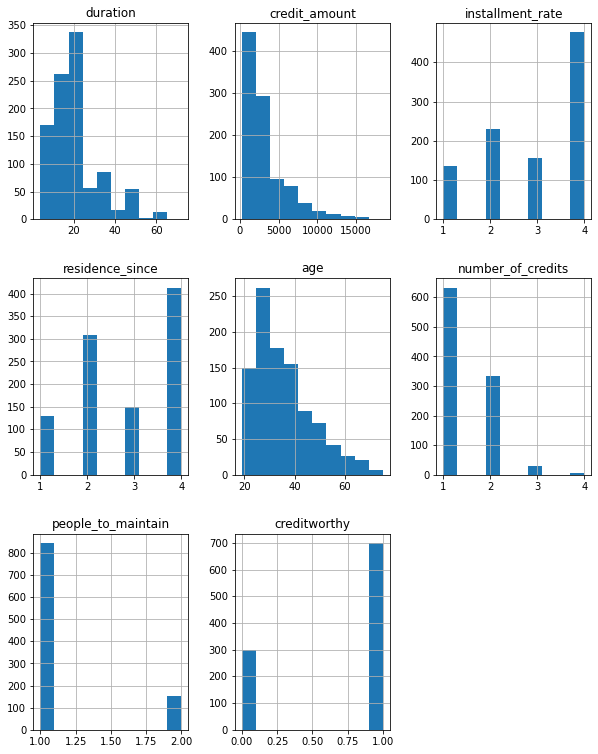

In [290]:
print(df.hist(figsize = (10,13)))

A93    548
A92    310
A94     92
A91     50
Name: personal_status_sex, dtype: int64


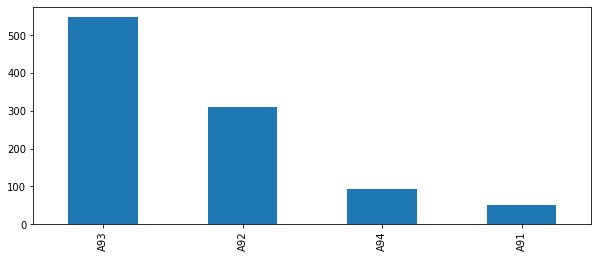

In [291]:
print(df['personal_status_sex'].value_counts())

fig, ax = plt.subplots(figsize=(10,4))
df['personal_status_sex'].value_counts().plot(kind='bar')
plt.show()
# A91: male: divorced/separated A92: female: divorced/separated/married
# A93: male: single # A94: male: married/widowed


In [292]:
df.groupby(['residence_since'])['creditworthy'].value_counts()


residence_since  creditworthy
1                1                94
                 0                36
2                1               211
                 0                97
3                1               106
                 0                43
4                1               289
                 0               124
Name: creditworthy, dtype: int64

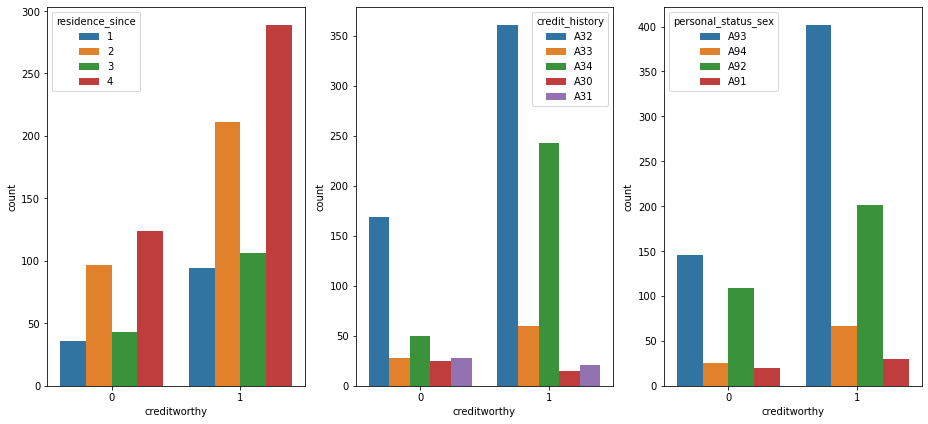

In [293]:
_, axes = plt.subplots(1, 3, figsize=(13,6))

sns.countplot(x='creditworthy', hue='residence_since', data=df, ax=axes[0]);
sns.countplot(x='creditworthy', hue='credit_history', data=df, ax=axes[1]);
sns.countplot(x='creditworthy', hue='personal_status_sex', data=df, ax=axes[2]);
plt.tight_layout()

# Categorical

In [294]:
def categorical_numerical_split(df):
    categorical = [att for att in df.columns if df[att].dtype == 'object']
    numerical = [att for att in df.columns if df[att].dtype == 'int64']
    return categorical, numerical

categorical, numerical = categorical_numerical_split(df)

print(f'Categorical features:\n{categorical}\n')
print(f'Numerical features:\n{numerical}')


Categorical features:
['account_status', 'credit_history', 'purpose', 'savings_account', 'employment_since', 'personal_status_sex', 'guarantors', 'property', 'other_installment_plans', 'housing', 'job', 'phone', 'foreign_worker']

Numerical features:
['duration', 'credit_amount', 'installment_rate', 'residence_since', 'age', 'number_of_credits', 'people_to_maintain', 'creditworthy']


In [295]:
# return number of unique elements in the object

df[categorical].nunique()


account_status              4
credit_history              5
purpose                    11
savings_account             5
employment_since            6
personal_status_sex         4
guarantors                  3
property                    4
other_installment_plans     3
housing                     3
job                         5
phone                       2
foreign_worker              3
dtype: int64

In [296]:
# Feature representation

print("Unique categorical values:")
for att in df.select_dtypes(include=[object]):
    print(att,":", df[att].unique())
    

Unique categorical values:
account_status : ['A14' 'A12' 'A13' 'A11']
credit_history : ['A32' 'A33' 'A34' 'A30' 'A31']
purpose : ['?' 'A46' 'A40' 'A43' 'A41' 'A42' 'A49' 'A410' 'A45' 'A48' 'A44']
savings_account : ['A63' 'A65' 'A61' 'A64' 'A62']
employment_since : ['?' 'A73' 'A74' 'A75' 'A72' 'A71']
personal_status_sex : ['A93' 'A94' 'A92' 'A91']
guarantors : ['A101' 'A102' 'A103']
property : ['A123' 'A124' 'A121' 'A122']
other_installment_plans : ['A143' 'A141' 'A142']
housing : ['A152' 'A153' 'A151']
job : ['A173' '?' 'A174' 'A172' 'A171']
phone : ['A191' 'A192']
foreign_worker : ['?' 'A201' 'A202']


<b><h2>Encodes nominal features to numeric features</h2></b>

Many machine learning algorithms cannot operate on label data directly. They require all input variables and output variables to be numeric.<br>

return: data frame with all-numeric features

In [297]:
def str_to_num(df):
    # create a new df with categorical features only, encoded as numbers
    categorical, numerical = categorical_numerical_split(df)
    
    enc = LabelEncoder()
    df_encoded = df[categorical].apply(lambda x: enc.fit_transform(x))

    df_encoded_concat = pd.concat([df_encoded, df[numerical]], axis=1)
    
    # Create a dict to decode numeric values; returns a dictionary-like object
    d = defaultdict()
    
    for col_name in df[categorical]:
        # e.g.: account_status_A14 :  3
        for unique_str_val, unique_num_val in zip(df[col_name].unique(), df_encoded[col_name].unique()):
                d[col_name + '_' + unique_str_val] = unique_num_val            
    
    return df_encoded_concat , d


In [298]:
df_new_enc, df_new_enc_dict = str_to_num(df_new)

# Print out new numericaly encoded features
for k,v in df_new_enc_dict.items():
    print(k, ': ', v)
    

account_status_A14 :  3
account_status_A12 :  1
account_status_A13 :  2
account_status_A11 :  0
credit_history_A32 :  2
credit_history_A33 :  3
credit_history_A34 :  4
credit_history_A30 :  0
credit_history_A31 :  1
savings_account_A63 :  2
savings_account_A65 :  4
savings_account_A61 :  0
savings_account_A64 :  3
savings_account_A62 :  1
personal_status_sex_A93 :  2
personal_status_sex_A94 :  3
personal_status_sex_A92 :  1
personal_status_sex_A91 :  0
guarantors_A101 :  0
guarantors_A102 :  1
guarantors_A103 :  2
property_A123 :  2
property_A124 :  3
property_A121 :  0
property_A122 :  1
other_installment_plans_A143 :  2
other_installment_plans_A141 :  0
other_installment_plans_A142 :  1
housing_A152 :  1
housing_A153 :  2
housing_A151 :  0


In [299]:
# Make sure there are still 16 feature
print(df_new_enc.shape)


(1000, 16)


For categorical variables where no such ordinal relationship exists, a one-hot encoding can be applied to the integer representation. 

<b> One-Hot Encoding: </b> The integer encoded variable is removed and a new binary variable is added for each unique integer value.

<b>df:</b> dataframe

<b>to_one_hot:</b> list of columns to encode 

<b>return:</b> encoded df

In [300]:
def to_one_hot(df, verbose=False):
    categorical, numerical = categorical_numerical_split(df)
    
    # 1-hot encoding for the categorical variables
    df_only_one_hot = pd.get_dummies(df[categorical])
    
    if verbose == True:
        print(f'new 1-hot-encoded variables:\n {list(df_only_one_hot.columns)}')
    
    # Concatenate numerical and categorical data
    df_new_onehot = pd.concat([df[numerical], df_only_one_hot], axis = 1)
    
    if verbose == True:
        print(f'Shape: {df_new_onehot.shape}')
        df_new_onehot.head()
    
    return df_new_onehot


In [301]:
# Fatures that shoud be encoded for X_train
df_new_onehot = to_one_hot(df_new, verbose=True)


new 1-hot-encoded variables:
 ['account_status_A11', 'account_status_A12', 'account_status_A13', 'account_status_A14', 'credit_history_A30', 'credit_history_A31', 'credit_history_A32', 'credit_history_A33', 'credit_history_A34', 'savings_account_A61', 'savings_account_A62', 'savings_account_A63', 'savings_account_A64', 'savings_account_A65', 'personal_status_sex_A91', 'personal_status_sex_A92', 'personal_status_sex_A93', 'personal_status_sex_A94', 'guarantors_A101', 'guarantors_A102', 'guarantors_A103', 'property_A121', 'property_A122', 'property_A123', 'property_A124', 'other_installment_plans_A141', 'other_installment_plans_A142', 'other_installment_plans_A143', 'housing_A151', 'housing_A152', 'housing_A153']
Shape: (1000, 39)


In [302]:
df_new_onehot.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 39 columns):
 #   Column                        Non-Null Count  Dtype
---  ------                        --------------  -----
 0   duration                      1000 non-null   int64
 1   credit_amount                 1000 non-null   int64
 2   installment_rate              1000 non-null   int64
 3   residence_since               1000 non-null   int64
 4   age                           1000 non-null   int64
 5   number_of_credits             1000 non-null   int64
 6   people_to_maintain            1000 non-null   int64
 7   phone                         1000 non-null   int64
 8   account_status_A11            1000 non-null   uint8
 9   account_status_A12            1000 non-null   uint8
 10  account_status_A13            1000 non-null   uint8
 11  account_status_A14            1000 non-null   uint8
 12  credit_history_A30            1000 non-null   uint8
 13  credit_history_A31            1000

# Check the balanced of the dataset

1    700
0    300
Name: creditworthy, dtype: int64


<AxesSubplot:>

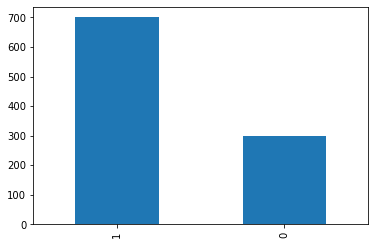

In [303]:
print(label.value_counts())
label.value_counts().plot(kind='bar', label= 'Target Values')
#1 = good, trustworthy and 0 = bad, Not trustworthy
#There are more than twice as many creditworthy examples


<h2><b>Synthetic Minority Over-sampling Technique</b></h2>

A problem with imbalanced classification is that there are too few examples of the minority class for a model to effectively learn the decision boundary. One way to solve this problem is to oversample the examples in the minority class.

The most common technique is called <b>SMOTE (Synthetic Minority Over-sampling Technique).</b>
In simple terms, it looks at the feature space for the minority class data points
and considers its k nearest neighbours.

In [304]:
def balance_data(df,label):
    sm = SMOTE(random_state=7)

    # Fit the model to generate the data.
    cols = df.columns
    df, label = sm.fit_resample(df, label)
    df = pd.DataFrame(df)
    label = pd.Series(label)

    df.columns = cols
    
    return df,label


0    700
1    700
Name: creditworthy, dtype: int64


<AxesSubplot:>

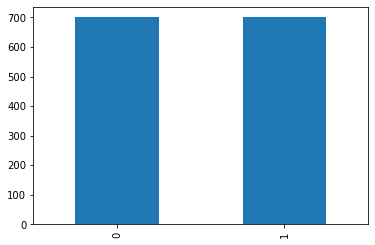

In [305]:
label_orig = label
df_new_enc, label_enc = balance_data(df_new_enc,label_orig)
df_new_onehot, label_onehot = balance_data(df_new_onehot, label_orig)

print(label_enc.value_counts())

label_enc.value_counts().plot(kind='bar', label= 'Target Values')

#1 = good, trustworthy and 0 = bad, Not trustworthy


In [306]:
df_new_enc.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1400 entries, 0 to 1399
Data columns (total 16 columns):
 #   Column                   Non-Null Count  Dtype
---  ------                   --------------  -----
 0   account_status           1400 non-null   int32
 1   credit_history           1400 non-null   int32
 2   savings_account          1400 non-null   int32
 3   personal_status_sex      1400 non-null   int32
 4   guarantors               1400 non-null   int32
 5   property                 1400 non-null   int32
 6   other_installment_plans  1400 non-null   int32
 7   housing                  1400 non-null   int32
 8   duration                 1400 non-null   int64
 9   credit_amount            1400 non-null   int64
 10  installment_rate         1400 non-null   int64
 11  residence_since          1400 non-null   int64
 12  age                      1400 non-null   int64
 13  number_of_credits        1400 non-null   int64
 14  people_to_maintain       1400 non-null   int64
 15  phon

(1400, 39)


<AxesSubplot:>

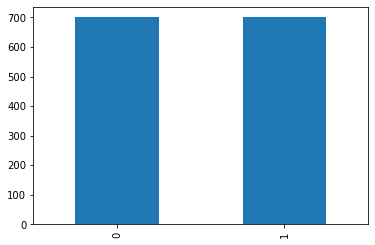

In [307]:
print(df_new_onehot.shape)
label_onehot.value_counts().plot(kind='bar', label= 'Target Values')

#1 = good, trustworthy and 0 = bad, Not trustworthy


# Evaluation Functions

In [308]:
#10-fold Cross Validation on training and validation data
def cross_validate(clf, X_train, y_train, metrics=['precision', 'accuracy']):
    for metric in metrics: 
        scores = cross_val_score(clf, X_train, y_train, cv=10, scoring=metric)
        # The mean score and standard deviation of the score estimate
        print("Cross Validation %s: %0.2f (+/- %0.2f)" % (metric, scores.mean(), scores.std()))
    
    return 

#Fits classifier
def train(clf, X_train, y_train):
    print(f'Training a {clf.__class__.__name__}')
    print(f'with a training set size of {len(X_train)}')
    clf.fit(X_train, y_train)
    return clf

#Predict on unseen test data
def predict(clf, X_test):    
    y_pred = clf.predict(X_test)
    return y_pred


In [309]:
#Evaluate on Precision and Accuracy
def evaluate_test(y_test, y_pred):
    print(f'Test Precision Score: {precision_score(y_test, y_pred)}')
    print(f'Test Recall Score: {recall_score(y_test, y_pred)}')
    print(f'Test Accuracy Score: {accuracy_score(y_test, y_pred)}')   
    print(f'Test F1-score Score: {f1_score(y_test, y_pred)}')
    
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    print(f'Test Confusion Matrix: \n {confusion_matrix(y_test, y_pred)}')
    print(f'Number of False Positives: {fp}')
    
    return 

def train_predict(clf, X_train, y_train, X_test, y_test=None):
    # Train the classifier
    clf = train(clf, X_train, y_train)
    
    # Predict labes
    y_pred = predict(clf, X_test)
    
    return y_pred


# Random Forest

<b>Entropy:</b> $$H_{L}(x_{j}) = -\sum \limits _{v = 1}^{k} P(y=v) * \log_2 P(y=v)$$
<b>Information Gain:</b> $$IG_{L}(x_{j}) = H_{L}(y) - \sum \limits _{v = 1}^{k} P_{L}(x_{j}=v) * H_{L} (y | x_{j} = v)$$
<b>Information Gain Ratio:</b> $$ GR_{L} (x_{j}) = \frac{IG_{L}(x_{j})}{H_{L}(x_{j})} $$

In [310]:
df_news = [df_new_enc, df_new_onehot]
labels = [label_enc, label_onehot]
names = ['Numerically Encoded Features: ', 'One-hot Encoded Features']

for df_new_encoded, lab, name in zip(df_news, labels, names):
    print('\n',name)
    print(df_new_encoded.shape)
    # Spliting X and y into train and test version
    X_train, X_test, y_train, y_test = train_test_split(df_new_encoded, lab, test_size = 0.25, random_state=4)

    clf = RandomForestClassifier(n_estimators=100, random_state=33)
    y_pred = train_predict(clf, X_train, y_train, X_test, y_test)
    evaluate_test(y_test, y_pred)
    


 Numerically Encoded Features: 
(1400, 16)
Training a RandomForestClassifier
with a training set size of 1050
Test Precision Score: 0.8268156424581006
Test Recall Score: 0.8176795580110497
Test Accuracy Score: 0.8171428571428572
Test F1-score Score: 0.8222222222222223
Test Confusion Matrix: 
 [[138  31]
 [ 33 148]]
Number of False Positives: 31

 One-hot Encoded Features
(1400, 39)
Training a RandomForestClassifier
with a training set size of 1050
Test Precision Score: 0.8369565217391305
Test Recall Score: 0.850828729281768
Test Accuracy Score: 0.8371428571428572
Test F1-score Score: 0.8438356164383561
Test Confusion Matrix: 
 [[139  30]
 [ 27 154]]
Number of False Positives: 30


In [311]:
'''
One-hot Encoded Features
(1400, 39)
Training a RandomForestClassifier
with a training set size of 1050
Test Precision Score: 0.8369565217391305
Test Recall Score: 0.850828729281768
Test Accuracy Score: 0.8371428571428572
Test F1-score Score: 0.8438356164383561
Test Confusion Matrix: 
 [[139  30]
 [ 27 154]]
Number of False Positives: 30
'''


'\nOne-hot Encoded Features\n(1400, 39)\nTraining a RandomForestClassifier\nwith a training set size of 1050\nTest Precision Score: 0.8369565217391305\nTest Recall Score: 0.850828729281768\nTest Accuracy Score: 0.8371428571428572\nTest F1-score Score: 0.8438356164383561\nTest Confusion Matrix: \n [[139  30]\n [ 27 154]]\nNumber of False Positives: 30\n'

In [312]:
X_train, X_test, y_train, y_test = train_test_split(df_new_enc, label_enc, test_size = 0.25)

train_accuracies = []
test_accuracies = []

for i in range(1,50):
    clf = RandomForestClassifier(n_estimators=i, max_depth=i)
    clf.fit(X_train, y_train)
    score_train = clf.score(X_train,y_train)
    score_test = clf.score(X_test,y_test)
    train_accuracies.append(score_train)
    test_accuracies.append(score_test)
    

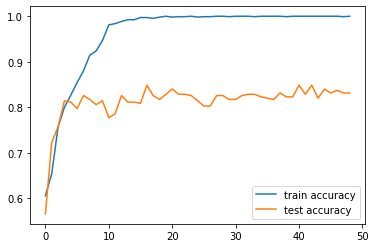

In [313]:
plt.plot(train_accuracies, label='train accuracy')
plt.plot(test_accuracies, label='test accuracy')
plt.legend()
plt.show()


In [314]:
X_train, X_test, y_train, y_test = train_test_split(df_new_onehot, label_onehot, test_size = 0.25)

train_accuracies = []
test_accuracies = []

for i in range(1,50):
    clf = RandomForestClassifier(n_estimators=i, max_depth=i)
    clf.fit(X_train, y_train)
    score_train = clf.score(X_train,y_train)
    score_test = clf.score(X_test,y_test)
    train_accuracies.append(score_train)
    test_accuracies.append(score_test)
    

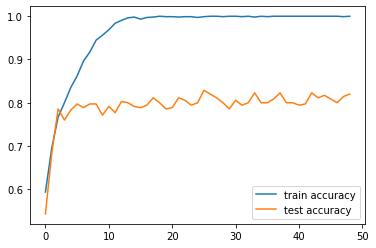

In [315]:
plt.plot(train_accuracies, label='train accuracy')
plt.plot(test_accuracies, label='test accuracy')
plt.legend()
plt.show()


# Visualize the most important features

Feature importance refers to techniques that assign a score to input features based on how useful they are at predicting a target variable.

In [316]:
def display_feature_importance(trained_clf):

    # Print the name and gini importance of each feature
    importances = trained_clf.feature_importances_
    print(f'\n Feature Importance, sums up to 1:')
    for feature in zip(X_train.columns, importances):
        print(feature)
        
    # Visualise Feature Importance:
    indices = np.argsort(trained_clf.feature_importances_)
    plt.figure(figsize=(10,8))
    plt.title('Feature Importances')
    plt.barh(range(len(indices)), importances[indices], color='g', align='center')
    plt.yticks(range(len(indices)), [X_train.columns[i] for i in indices])
    plt.xlabel('Relative Importance')
    plt.show()
    
    return 


Training a RandomForestClassifier
with a training set size of 1050

 Feature Importance, sums up to 1:
('account_status', 0.17058679969783522)
('credit_history', 0.08787037476165746)
('savings_account', 0.06498362099309268)
('personal_status_sex', 0.04764662374034565)
('guarantors', 0.024890671550702424)
('property', 0.04094636715737807)
('other_installment_plans', 0.03749919121430121)
('housing', 0.03009462901589212)
('duration', 0.10851410724554553)
('credit_amount', 0.13894483351482856)
('installment_rate', 0.04112159647487169)
('residence_since', 0.0460550996912245)
('age', 0.1014320470617651)
('number_of_credits', 0.01738205446561704)
('people_to_maintain', 0.013440604377461812)
('phone', 0.028591379037480942)


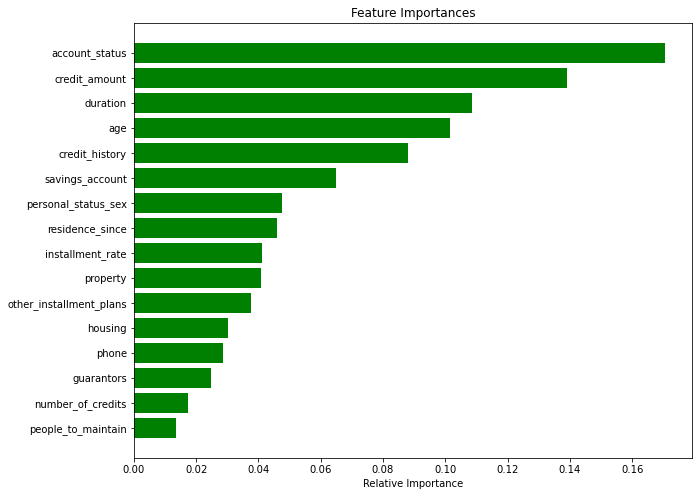

In [317]:
X_train, X_test, y_train, y_test = train_test_split(df_new_enc, label_enc, test_size = 0.25)

clf_enc = RandomForestClassifier()
y_pred = train_predict(clf_enc, X_train, y_train, X_test, y_test)
display_feature_importance(clf_enc)


<img src="pic1.png">

Training a RandomForestClassifier
with a training set size of 1050

 Feature Importance, sums up to 1:
('duration', 0.08141877472166169)
('credit_amount', 0.09276532843932758)
('installment_rate', 0.03147512791962404)
('residence_since', 0.0430502531788423)
('age', 0.07014670064486331)
('number_of_credits', 0.022683447567730965)
('people_to_maintain', 0.011623241771648569)
('phone', 0.02215493266116388)
('account_status_A11', 0.01796234022088194)
('account_status_A12', 0.022534062616828807)
('account_status_A13', 0.015948855434625087)
('account_status_A14', 0.12119302278098117)
('credit_history_A30', 0.004186943269417636)
('credit_history_A31', 0.006642973374237075)
('credit_history_A32', 0.020047305097138972)
('credit_history_A33', 0.013894100139606062)
('credit_history_A34', 0.04442415546251523)
('savings_account_A61', 0.015286202776122632)
('savings_account_A62', 0.009873045327806666)
('savings_account_A63', 0.007515383727028627)
('savings_account_A64', 0.0079581620524452)
('savings

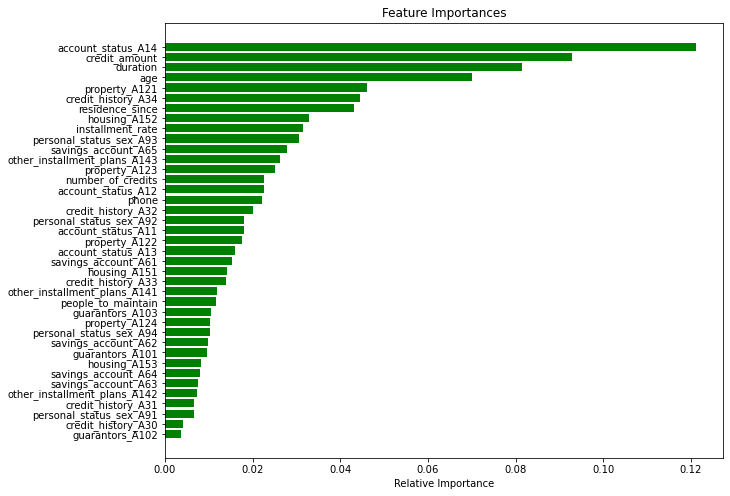

In [318]:
X_train, X_test, y_train, y_test = train_test_split(df_new_onehot, label_onehot, test_size = 0.25)

clf_onehot = RandomForestClassifier()
y_pred = train_predict(clf_onehot, X_train, y_train, X_test, y_test)
display_feature_importance(clf_onehot)


<img src="pic2.png">

# Correlation Matrix between features

A correlation matrix is a table showing correlation coefficients between variables. The measure is best used in variables that demonstrate a linear relationship between each other.

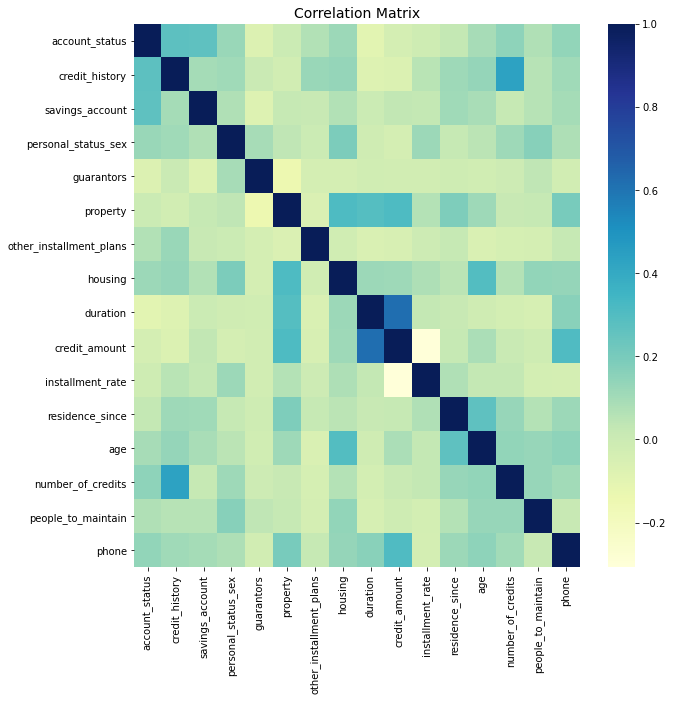

In [319]:
def plot_corr_matrix(df):
    # Sample figsize in inches
    fig, ax = plt.subplots(figsize=(10,10))         
    
    corr = df.corr() # find the pairwise correlation of all columns in the dataframe
    sns.heatmap(corr, cmap='YlGnBu', ax=ax)
    ax.set_title("Correlation Matrix", fontsize=14)
    plt.show()
    return

plot_corr_matrix(df_new_enc)


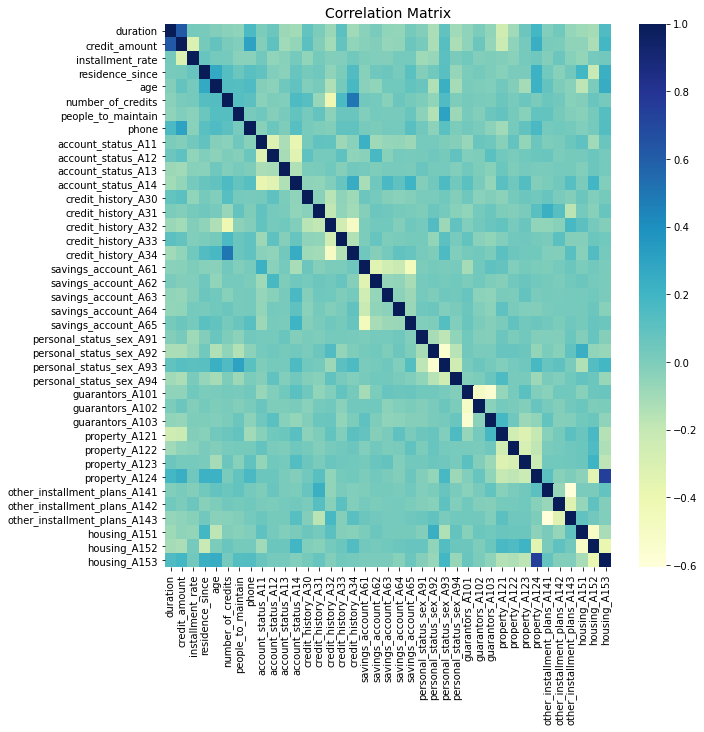

In [320]:
def plot_corr_matrix(df):
    # Sample figsize in inches
    fig, ax = plt.subplots(figsize=(10,10))         
    # Imbalanced DataFrame Correlation
    corr = df.corr()
    sns.heatmap(corr, cmap='YlGnBu', ax=ax)
    ax.set_title("Correlation Matrix", fontsize=14)
    plt.show()
    return

plot_corr_matrix(df_new_onehot)


# Other Classifier

In [321]:
def other_classifier_result(clf, X_train, y_train, X_test, y_test):
    y_pred = train_predict(clf, X_train, y_train, X_test, y_test)
    evaluate_test(y_test, y_pred)
        

In [322]:
def other_classifier_confusion(clf, X_train, y_train, X_test, y_test):
    class_names = np.array([0, 1])
                           
    titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
    
    for title, normalize in titles_options:
        disp = plot_confusion_matrix(clf, X_test, y_test,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
        disp.ax_.set_title(title) 
        
        print(title)
        
        print(disp.confusion_matrix)

In [323]:
X_train, X_test, y_train, y_test = train_test_split(df_new_enc, label_onehot, test_size = 0.25)

In [324]:
clf_svm = SVC(random_state = 9, kernel='linear')
other_classifier_result(clf_svm, X_train, y_train, X_test, y_test)

Training a SVC
with a training set size of 1050
Test Precision Score: 0.8117647058823529
Test Recall Score: 0.7976878612716763
Test Accuracy Score: 0.8085714285714286
Test F1-score Score: 0.80466472303207
Test Confusion Matrix: 
 [[145  32]
 [ 35 138]]
Number of False Positives: 32


Confusion matrix, without normalization
[[145  32]
 [ 35 138]]
Normalized confusion matrix
[[0.81920904 0.18079096]
 [0.20231214 0.79768786]]


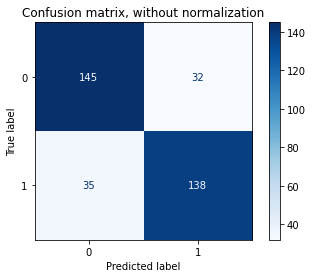

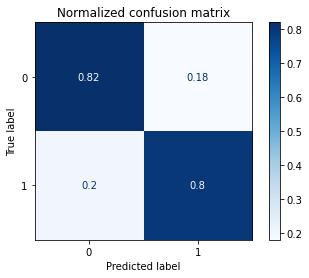

In [325]:
other_classifier_confusion(clf_svm, X_train, y_train, X_test, y_test)

In [326]:
clf_log_reg = LogisticRegression(solver='liblinear')
other_classifier_result(clf_log_reg, X_train, y_train, X_test, y_test)

Training a LogisticRegression
with a training set size of 1050
Test Precision Score: 0.8064516129032258
Test Recall Score: 0.8670520231213873
Test Accuracy Score: 0.8314285714285714
Test F1-score Score: 0.8356545961002785
Test Confusion Matrix: 
 [[141  36]
 [ 23 150]]
Number of False Positives: 36


Confusion matrix, without normalization
[[141  36]
 [ 23 150]]
Normalized confusion matrix
[[0.79661017 0.20338983]
 [0.13294798 0.86705202]]


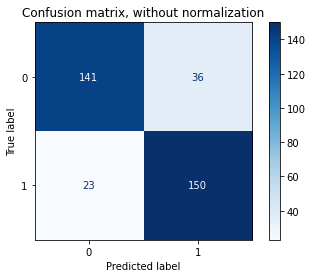

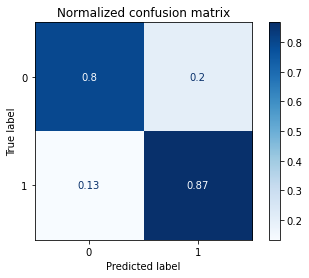

In [327]:
other_classifier_confusion(clf_log_reg, X_train, y_train, X_test, y_test)

In [328]:
clf_tree = DecisionTreeClassifier(criterion='entropy', max_depth=8, min_samples_split=5, splitter = 'best', min_samples_leaf = 25)
other_classifier_result(clf_tree, X_train, y_train, X_test, y_test)


Training a DecisionTreeClassifier
with a training set size of 1050
Test Precision Score: 0.8238993710691824
Test Recall Score: 0.7572254335260116
Test Accuracy Score: 0.8
Test F1-score Score: 0.7891566265060241
Test Confusion Matrix: 
 [[149  28]
 [ 42 131]]
Number of False Positives: 28


Confusion matrix, without normalization
[[149  28]
 [ 42 131]]
Normalized confusion matrix
[[0.84180791 0.15819209]
 [0.24277457 0.75722543]]


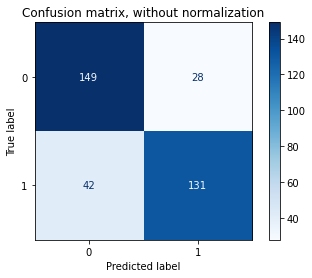

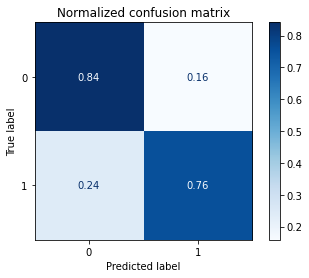

In [329]:
other_classifier_confusion(clf_tree, X_train, y_train, X_test, y_test)

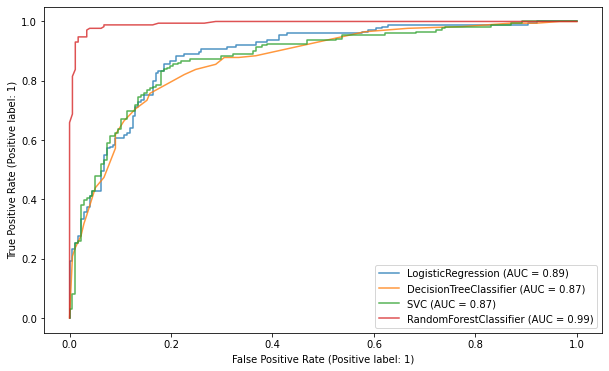

In [334]:
ax = plt.gca()

clf_log_reg_disp = plot_roc_curve(clf_log_reg, X_test, y_test, ax=ax, alpha=0.8)
clf_tree_disp = plot_roc_curve(clf_tree, X_test, y_test, ax=ax, alpha=0.8)
clf_svm_disp = plot_roc_curve(clf_svm, X_test, y_test, ax=ax, alpha=0.8)
clf_enc_disp = plot_roc_curve(clf_enc, X_test, y_test, ax=ax, alpha=0.8)

ax.figure.set_size_inches(10, 6)
plt.show()

In [335]:
X_train, X_test, y_train, y_test = train_test_split(df_new_onehot, label_onehot, test_size = 0.25)


In [336]:
clf_svm = SVC(random_state = 9, kernel='linear')
other_classifier_result(clf_svm, X_train, y_train, X_test, y_test)


Training a SVC
with a training set size of 1050
Test Precision Score: 0.7710843373493976
Test Recall Score: 0.735632183908046
Test Accuracy Score: 0.76
Test F1-score Score: 0.7529411764705882
Test Confusion Matrix: 
 [[138  38]
 [ 46 128]]
Number of False Positives: 38


Confusion matrix, without normalization
[[138  38]
 [ 46 128]]
Normalized confusion matrix
[[0.78409091 0.21590909]
 [0.26436782 0.73563218]]


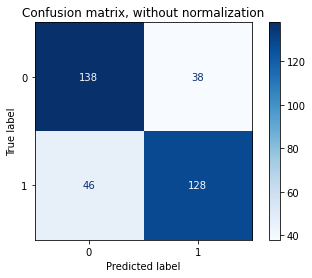

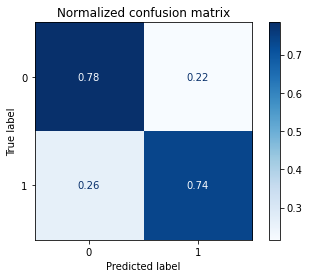

In [337]:
other_classifier_confusion(clf_svm, X_train, y_train, X_test, y_test)

In [338]:
clf_log_reg = LogisticRegression(solver='liblinear')
other_classifier_result(clf_log_reg, X_train, y_train, X_test, y_test)


Training a LogisticRegression
with a training set size of 1050
Test Precision Score: 0.7589743589743589
Test Recall Score: 0.8505747126436781
Test Accuracy Score: 0.7914285714285715
Test F1-score Score: 0.8021680216802167
Test Confusion Matrix: 
 [[129  47]
 [ 26 148]]
Number of False Positives: 47


Confusion matrix, without normalization
[[129  47]
 [ 26 148]]
Normalized confusion matrix
[[0.73295455 0.26704545]
 [0.14942529 0.85057471]]


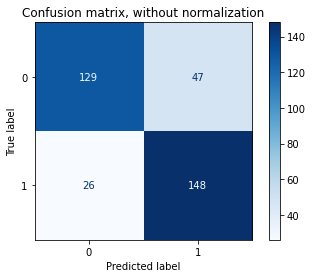

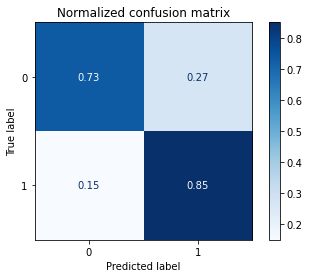

In [339]:
other_classifier_confusion(clf_log_reg, X_train, y_train, X_test, y_test)

In [340]:
clf_tree = DecisionTreeClassifier(criterion='entropy', max_depth=8, min_samples_split=5, splitter = 'best', min_samples_leaf = 25)
other_classifier_result(clf_tree, X_train, y_train, X_test, y_test)


Training a DecisionTreeClassifier
with a training set size of 1050
Test Precision Score: 0.7606382978723404
Test Recall Score: 0.8218390804597702
Test Accuracy Score: 0.7828571428571428
Test F1-score Score: 0.7900552486187845
Test Confusion Matrix: 
 [[131  45]
 [ 31 143]]
Number of False Positives: 45


Confusion matrix, without normalization
[[131  45]
 [ 31 143]]
Normalized confusion matrix
[[0.74431818 0.25568182]
 [0.17816092 0.82183908]]


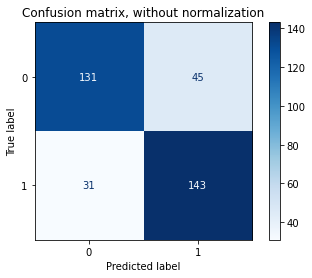

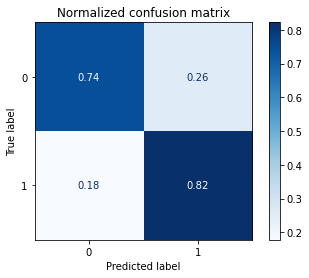

In [341]:
other_classifier_confusion(clf_tree, X_train, y_train, X_test, y_test)

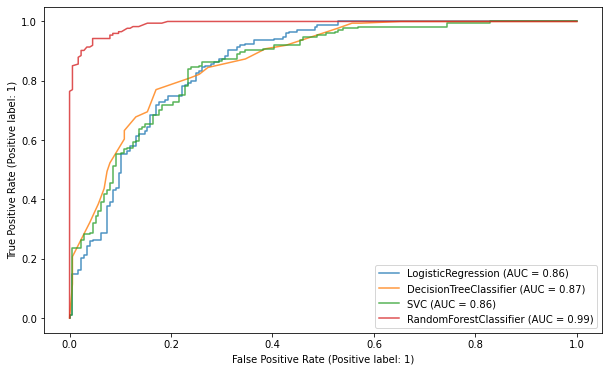

In [342]:
ax = plt.gca()

clf_log_reg_disp = plot_roc_curve(clf_log_reg, X_test, y_test, ax=ax, alpha=0.8)
clf_tree_disp = plot_roc_curve(clf_tree, X_test, y_test, ax=ax, alpha=0.8)
clf_svm_disp = plot_roc_curve(clf_svm, X_test, y_test, ax=ax, alpha=0.8)
clf_onehot_disp = plot_roc_curve(clf_onehot, X_test, y_test, ax=ax, alpha=0.8)

ax.figure.set_size_inches(10, 6)
plt.show()
